<a id='top'></a>

# CSCI3022 S22



# Homework 7: Bootstrapping and SLR

## Due Monday, April 18 at 11:59 pm to Canvas and Gradescope
***

**Name**: ________________________________________________________________________

***

Your solutions to computational questions should include any specified Python code and results as well as written commentary on your conclusions.  Remember that you are encouraged to discuss the problems with your classmates, but **you must write all code and solutions on your own**.

**NOTES**: 

- Any relevant data sets should be available on Canvas. To make life easier on the graders if they need to run your code, do not change the relative path names here. Instead, move the files around on your computer.
- If you're not familiar with typesetting math directly into Markdown then by all means, do your work on paper first and then typeset it later.  Here is a [reference guide](https://math.meta.stackexchange.com/questions/5020/mathjax-basic-tutorial-and-quick-reference) linked on Canvas on writing math in Markdown. **All** of your written commentary, justifications and mathematical work should be in Markdown.  I also recommend the [wikibook](https://en.wikibooks.org/wiki/LaTeX) for LaTex.
- Because you can technically evaluate notebook cells is a non-linear order, it's a good idea to do **Kernel $\rightarrow$ Restart & Run All** as a check before submitting your solutions.  That way if we need to run your code you will know that it will work as expected. 
- It is **bad form** to make your reader interpret numerical output from your code.  If a question asks you to compute some value from the data you should show your code output **AND** write a summary of the results in Markdown directly below your code. 
- 45 points of this assignment are in problems.  The remaining 5 are for neatness, style, and overall exposition of both code and text.
- This probably goes without saying, but... For any question that asks you to calculate something, you **must show all work and justify your answers to receive credit**. Sparse or nonexistent work will receive sparse or nonexistent credit. 
- There is *not a prescribed API* for these problems.  You may answer coding questions with whatever syntax or object typing you deem fit.  Your evaluation will primarily live in the clarity of how well you present your final results, so don't skip over any interpretations!  Your code should still be commented and readable to ensure you followed the given course algorithm.
- There are two ways to quickly make a .pdf out of this notebook for Gradescope submission.  Either:
 - Use File -> Download as PDF via LaTeX.  This will require your system path find a working install of a TeX compiler
 - Easier: Use File ->  Print Preview, and then Right-Click -> Print using your default browser and "Print to PDF"



In [1]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import scipy.stats as stats
import statsmodels.api as sm
from patsy import dmatrices
%matplotlib inline

C:\Users\zacha\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools



---
**Shortcuts:**  [Problem 1](#p1) | [Problem 2](#p2) |
---


<br>

---
<a/ id='p1'></a>
[Back to top](#top)
## Problem 1 (Small Samples; 20 points)

Consider the `hubble.csv` data set we used in nb15. In that example, we used the large-sample normal approximation and used it to calculate a confidence interval for the mean of a galaxy's distance from Earth in Mega parsecs (column `x` of the data).

Unfortunately, the data was only 24 observations!  What could we have done instead?


In [2]:
# Path to the data - select the path that works for you 
file_path = '../data/hubble.csv'

# Load the data into a DataFrame 
df = pd.read_csv(file_path)
df.head(10)

,Galaxy,y,x
0,NGC0300,133,2.00
1,NGC0925,664,9.16
2,NGC1326A,1794,16.14
3,NGC1365,1594,17.95
4,NGC1425,1473,21.88
5,NGC2403,278,3.22
6,NGC2541,714,11.22
7,NGC2090,882,11.75
8,NGC3031,80,3.63
9,NGC3198,772,13.80



**Part A**:

Make a histogram of the data and overlay the theoretical density of the normal with mean $\bar{X}$ and variance $s^2$.  How closely do the data follow the histogram?


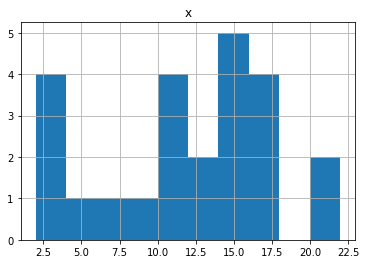

In [3]:
df.hist(column=['x'], bins=10);

**Part B**:

Things may not look perfectly normal in part A... but let's perform the tests that require normality anyways:

For Part B only, assume each observation is independent and identically distributed as a normal random variable.

- Create a 95% confidence interval for the mean of a galaxy's distance from Earth in Mega parsecs.
- Create a 95% confidence interval for the standard deviation of a galaxy's distance from Earth in Mega parsecs.

In [4]:
n=len(df)
xbar=np.sum([df['x']])/n
sd=np.sqrt(np.sum([(xi-xbar)**2/(n-1) for xi in df['x']]))
critt=stats.t.ppf(.975, n-1)
print('Sample mean is:', xbar)
print('The t-CI is: ', xbar-critt*sd/np.sqrt(n),xbar+critt*sd/np.sqrt(n))
print('Via boxed fn:', stats.t.interval(.95, n-1, loc=xbar, scale=sd/np.sqrt(n)))

xbar=np.sum(df['x'])/n
sd=np.sqrt(np.sum((xi-xbar)**2/(n-1) for xi in df['x']))
critz=stats.t.ppf(.95, n-1)
print('Sample SD is:', sd)
print('The Chi-squared-SD-CI is: ', \
      np.sqrt(sd**2*(n-1)/stats.chi2.ppf(0.975, n-1)), \
      np.sqrt(sd**2*(n-1)/stats.chi2.ppf(0.025, n-1)))



Sample mean is: 12.054583333333333
The t-CI is:  9.599272544248016 14.50989412241865
Via boxed fn: (9.599272544248016, 14.50989412241865)
Sample SD is: 5.814648652263983
The Chi-squared-SD-CI is:  4.519223941819864 8.156560101133483


**Part C**:

For part C only, assume each observation is independent and identically distributed but is **not** normally distributed.  Instead, use bootstrapping to:

- Create a 95% confidence interval for the mean of a galaxy's distance from Earth in Mega parsecs.
- Create a 95% confidence interval for the standard deviation of a galaxy's distance from Earth in Mega parsecs.
- Create a 95% confidence interval for the interquartile range (both lower and upper quartiles) of a galaxy's distance from Earth in Mega parsecs.

Use 10,000 bootstrapped samples to make the statistics above.

In [5]:
nboot=10000
bootsamp=np.random.choice(df['x'], replace=True, size=(nboot,len(df)))

bootmeans=np.mean(bootsamp, axis=1)
bootsd=np.std(bootsamp, ddof=1, axis=1)
bootLQs=np.percentile(bootsamp, 25, axis=1)
bootUQs=np.percentile(bootsamp, 75, axis=1)
bootIQR=bootUQs-bootLQs


print('Bootstrapped CI for mean:', np.percentile(bootmeans, 2.5), np.percentile(bootmeans, 97.5))
print('Bootstrapped CI for SD:', np.percentile(bootsd, 2.5), np.percentile(bootsd, 97.5))
print('Bootstrapped CI for lower quartile:', np.percentile(bootLQs, 2.5), np.percentile(bootLQs, 97.5))
print('Bootstrapped CI for upper quartile:', np.percentile(bootUQs, 2.5), np.percentile(bootUQs, 97.5))
print('Bootstrapped CI for IQR:', np.percentile(bootIQR, 2.5), np.percentile(bootIQR, 97.5))


Bootstrapped CI for mean: 9.738322916666666 14.354635416666664
Bootstrapped CI for SD: 4.3292195822972905 6.8735423619406
Bootstrapped CI for lower quartile: 3.22 11.899999999999999
Bootstrapped CI for upper quartile: 14.065000000000001 17.95
Bootstrapped CI for IQR: 4.085000000000001 12.530000000000001


[Back to top](#top)

<a id='p2'></a>

## (25 pts) Problem 2 (Theory): Practice with SLR and Inference


In this problem we will explore the `mortality.csv` data introduced in notebook21.  In that notebook we found some linear regression coefficients and did a related hypothesis test.  In this exercise we will "finish" analysis on that data set by exploring and visualizing the underlying assumptions, and performing some more nuanced inference.

This data set has two variables:

- `Rate`; the annual mortality rate (as a percentage) over the years 1958–1964 of 61 towns in England and Wales.
- `Calc`; the recorded calcium concentration in the drinking water supply for those towns, in parts-per-million

In [6]:
# Path to the data - select the path that works for you 
file_path = '../data/mortality.csv'

# Load the data into a DataFrame 
df = pd.read_csv(file_path)
print(len(df))
df.head(10)

61


,Rate,Calc
0,1.247,105
1,1.392,73
2,1.260,21
3,1.259,133
4,1.236,101
5,1.627,53
6,1.581,14
7,1.609,18
8,1.755,12
9,1.723,44


Text(0,0.5,'Y')

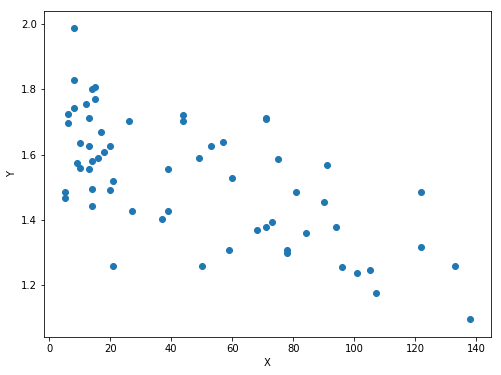

In [18]:
fig, ax= plt.subplots(figsize=(8,6))
ax.scatter(df['Calc'], df['Rate'])
ax.set_xlabel('X')
ax.set_ylabel('Y')

**A)** Perform a simple linear regression model using the `OLS` method from `statsmodels`.  Print the resulting `summary` table and then as a print statement or in a markdown cell typeset the actual line of best fit, using the coefficients from your fit.  (See: `.params`.)

In [7]:
#Solution:
y, x = dmatrices('Rate ~ Calc', data=df)
lm=sm.OLS(y,x).fit()
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   Rate   R-squared:                       0.429
Model:                            OLS   Adj. R-squared:                  0.419
Method:                 Least Squares   F-statistic:                     44.30
Date:                Fri, 22 Apr 2022   Prob (F-statistic):           1.03e-08
Time:                        12:28:51   Log-Likelihood:                 33.088
No. Observations:                  61   AIC:                            -62.18
Df Residuals:                      59   BIC:                            -57.96
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.6764      0.029     57.217      0.000       1.618       1.735
Calc          -0.0032      0.000     -6.656      0.000      -0.004      -0.002
==============================================================================
Omnibus:                        0.570   Durbin-Watson:                   1.624
Prob(Omnibus):                  0.752   Jarque-Bera (JB):                0.694
Skew:                           0.112   Prob(JB):                        0.707
Kurtosis:                       2.528   Cond. No.                         96.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [8]:
#Solution:
print('Coefficients: ', lm.params)
print('Best fit line was: Rate=', np.round(lm.params[0],5), '+(', np.round(lm.params[1],5),')* Calc')


Coefficients:  [ 1.6763556  -0.00322609]
Best fit line was: Rate= 1.67636 +( -0.00323 )* Calc



#### Part B: Visualize.  Make a figure contianing 3 side-by-side plots.  Lefthand plot: scatter plot of the data set with overlay the line of best least-squares fit.  Middle plot: histogram of *residuals* of best least-squares fit are the y-axis.  Righthand plot: scatter plot where the original x-values are the x-axis and the *residuals* are the y-axis.

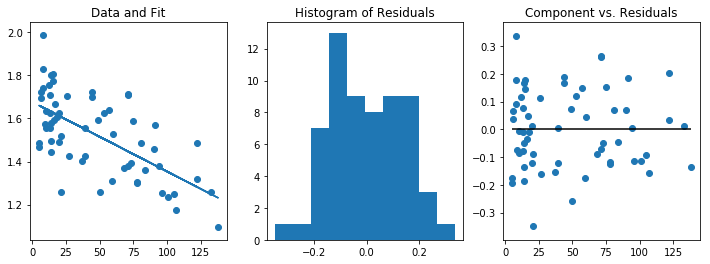

In [9]:
#all plots:
fig, ax= plt.subplots(figsize=(12,4), ncols=3)
ax[0].scatter(df['Calc'], df['Rate'])
ax[0].plot( df['Calc'], lm.fittedvalues)
ax[0].set_title('Data and Fit')
ax[1].hist(lm.resid)
ax[1].set_title('Histogram of Residuals')
ax[2].scatter(df['Calc'], lm.resid)
ax[2].set_title('Component vs. Residuals')
ax[2].hlines(0, xmin=np.min(df['Calc']), xmax=np.max(df['Calc']))

**Part C**: For each of the 4 major assumptions of the simple linear regression model, use your plots in part B to decide whether or not the data set meets those assumptions.

**Solution:**
- Does a straight line seem appropriate?  Linearity looks pretty good: the left-most plot has a clear downward trend, and it doesn't obviously require a curving line.
- Independence:do the x-values tell us things about the **sign** of the errors.  As you follow the right-most plot left-to-right, we notice a good mix of positive and negative y-values along the way.  This means we're probably ok, here.
- Homoskedasciticy: do the x-values tell us things about the **size** of the errors?  This also looks ok!  We have most of our data at smaller x-values, which in turn include our largest errors.  Otherwise the errors look pretty consistent as we look at the right-most plot.
- Normality: the shape of the errors is about a bell curve.  Here we use the histogram, and it's definitely bell-shaped, without too many extreme outliers.  Doesn't look too bad!


**D**: In the rest of this problem we will draw specific conclusions from our analysis and linear model.  For each prompt, you should provide both a numerical answer and a full sentence explaining the conclusion.

**D1)**:  How much of the variance in the mortality rates could be explained by the calcium in the drinking water?  Does this seem like a high value?

In [10]:
#Solution: this is the R^2 of our model!
print('Our model captured', 100*lm.rsquared, 'percentage of the overall variance in Mortality')

Our model captured 42.88267193124972 percentage of the overall variance in Mortality


**Solution:**

This is a lot for a social science type problem!  Note that this isn't about 42% of deaths, but rather: "of the amount that death rates vary from town-to-town, 42% of that appears to be accountable to Calcium amounts in the drinking water"

**D2)**:  A skeptic insists that "there's no way water quality is actually affecting death rates."  You decide that your linear model demonstrates other wise.  State the null and alternative hypotheses, and use the values on your `summary` table at a significance of $\alpha=0.01$ to argue against this skeptic.

In [11]:
proposed=0
tstat=np.abs(lm.params[1]-proposed)/(lm.bse[1])
tcrit=2*stats.t.ppf(0.995, len(df)-2)
print('Compare ', tstat, ' to ', tcrit, ' and reject?',tstat>tcrit)


Compare  6.655535174800663  to  5.3235175069973675  and reject? True


**Solution:**

This is already on our summary table!  We can just look at the p-value for the "slope" of `Calc`, and since it's very small (less than 0.001), we would conclude that it definitely **isn't** a slope of zero.  This correponds to testing:
$$H_0: \beta_1=0$$
against
$$H_A: \beta_1\ne0$$


**D3)**:  The government decides they believe your analysis in **D2)** that `Calc` values matter, but augmenting the drinking supply with Calcium is costly.  They insist that they don't actually want to take any actions unless you can demonstrate that the effects of `Calc` concentration on mortality `Rate` are *large enough*.  In particular, they will implement a calcification campaign if and only if you can demonstrate that at a significance of $\alpha=0.01$ one part-per-million of `Calcium` decreases mortality rate by more than 0.0025 percentage.

State the null and alternative hypotheses, and use the values on your summary table to recommend an action to the government.

**Solution:**

This isn't on our summary table, but it's **really close**.  This time we're testing
$$H_0: \beta_1=-0.0025$$
against
$$H_A: \beta_1<-0.0025$$

And as in the table before, it's a $t$-test.  But instead of a statistic of 
$$t=\frac{estimated \, slope}{s.e.(slope)}$$
we will now test
$$t=\frac{estimated \, slope - (-0.0025)}{s.e.(slope)}$$


In [12]:
proposed=-0.0025
tstat=(lm.params[1]-proposed)/(lm.bse[1])
tcrit=stats.t.ppf(0.01, len(df)-2)
print('Compare ', tstat, ' to ', tcrit, ' and reject?',tstat<tcrit)


Compare  -1.4979513340948107  to  -2.3912288325162177  and reject? False


The effect of Calcium is not **clearly** larger (more negative) than a slope of -0.0025 $\frac{\text{change in mortality %}}{\text{change in ppm of Calcium}}$

**D4)**:  The town of Manchester and their football clubs are loathsome.  While the town wasn't originally tested, we are told that the calcium concentration in their drinking water is exactly 100 ppm.

What is the 95% **prediction** interval for the mortality rate in Manchester?  In other words, given our linear model, what is the interval that we think should contain the actual mortality rate for Manchester?

What is the 95% **confidence** interval for the mortality rate in Manchester?  In other words, what is the interval that we think should contain the **mean** mortality rate for any town with a Calcium concentration of 100 ppm?


In [13]:
#These are prediction and confidence bands!
preds=lm.get_prediction(np.array([1,100]))
preds.summary_frame(alpha=0.05)

,mean,mean_se,mean_ci_lower,mean_ci_upper,obs_ci_lower,obs_ci_upper
0,1.353746,0.031478,1.290759,1.416734,1.060696,1.646797


For Manchester itself, we think the prediction interval is the wider of these two intervals:
$$[1.060696,1.646797]$$

We think the confidence interval or mean for cities with 100 ppm is the narrower one, since we're more sure of where the mean is (where the line goes) than we are of where the line plus the error/noise/variability should go:

$$[1.290759,1.416734]$$

## [Back to top](#top)
